In [2]:
cd ..

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier


In [3]:
from src.d04_mixmatch.wideresnet import WideResNet
from src.d02_data.load_data import get_dataloaders_validation
from src.d03_processing.transform_data import AddGaussianNoise
from src.d07_visualization.visualize_cifar10 import show_img
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import numpy as np
import time

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


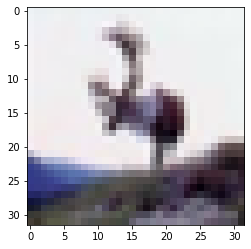

In [7]:
# Get data
train_loader, val_loader, test_loader = get_dataloaders_validation(path='data', 
                                                                   batch_size=64, train_size=1000, val_size=0)
show_img(iter(train_loader).next()[0][0])

In [8]:
# Init model
model = WideResNet(depth=28, k=2, n_out=10)


In [9]:
class Augment:
    def __init__(self, K=2):
        self.K = K
        self.transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                            transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
                                            AddGaussianNoise(mean=0, std=0.15)])

    def __call__(self, batch):
        augmented_batch = torch.zeros((self.K, *batch.shape))
        for k in range(self.K):
            augmented_batch[k] = self.transform(batch)
        return augmented_batch

In [18]:
class MixMatch(object):

    def __init__(self, model, batch_size, T=0.5, K=2, alpha=0.75):
        self.T = T
        self.K = K
        self.batch_size = batch_size
        self.alpha = alpha
        self.softmax = nn.Softmax(dim=1)
        self.model = model
        self.n_labels = 10 # Warning! hardcoded
        self.beta = torch.distributions.beta.Beta(alpha, alpha)

    def run(self, x_imgs, x_labels, u_imgs):
        # One hot encoding
        x_labels = self.one_hot_encoding(x_labels)

        # Augment
        augment_once = Augment(K=1)
        augment_k = Augment(K=self.K)
        
        x_hat = augment_once(x_imgs) # shape (1, batch_size, 3, 32, 32)
        u_hat = augment_k(u_imgs)    # shape (K, batch_size, 3, 32, 32)
        
        # Generate guessed labels
        start_t =time.time()
        q_bar = self.guess_label(u_hat)
        print('guessing labels time: ', str(time.time() - start_t))
        q = self.sharpen(q_bar)      # shape (K, batch_size, 10)

        x_hat = x_hat.reshape((-1, 3, 32, 32))      # shape (batch_size, 3, 32, 32)
        u_hat = u_hat.reshape((-1, 3, 32, 32))      # shape (K*batch_size, 3, 32, 32)
        q = q.repeat(self.K,1,1).reshape(-1, 10)    # shape (K*batch_size, 10)
        
        # Concat and shuffle
        w_imgs = torch.cat((x_hat, u_hat))
        w_labels = torch.cat((x_labels, q))
        w_imgs, w_labels = self.shuffle_matrices(w_imgs, w_labels)
        
        # Apply MixUp
        x_prime, p_prime = self.mixup(x_hat, w_imgs[:self.batch_size], x_labels, w_labels[:self.batch_size])
        u_prime, q_prime = self.mixup(u_hat, w_imgs[self.batch_size:], q, w_labels[self.batch_size:])
        
        return (x_prime, p_prime), (u_prime, q_prime), q_bar
    
    def mixup(self, x1, x2, p1, p2):
        n_samples = x1.shape[0]
        lambda_rand = self.beta.sample([n_samples, 1, 1, 1]) # one lambda per sample
        lambda_prime = torch.max(lambda_rand, 1-lambda_rand)
        x_prime = lambda_prime*x1 + (1-lambda_prime)*x2
        lambda_prime = lambda_prime.reshape(-1, 1)
        p_prime = lambda_prime*p1 + (1-lambda_prime)*p2
        return x_prime, p_prime
    
    def sharpen(self, q_bar):
        q_bar = q_bar.numpy()
        q = np.power(q_bar, 1/self.T) / np.sum(np.power(q_bar, 1/self.T), axis=1)[:, np.newaxis]
        return torch.from_numpy(q)
    
    def guess_label(self, u_hat):        
        self.model.eval()
        with torch.no_grad():
            q_bar = torch.zeros([self.batch_size, self.n_labels])
            for k in range(self.K):
                q_bar += self.softmax(self.model(u_hat[k]))
            q_bar /= self.K
            
        self.model.train()
        return q_bar

    def one_hot_encoding(self, labels):
        shape = (labels.shape[0], self.n_labels)
        one_hot = np.zeros(shape)
        rows = np.arange(labels.shape[0])
        one_hot[rows, labels] = 1
        return torch.from_numpy(one_hot)
    
    # shuffles along the first axis (axis 0)
    def shuffle_matrices(self, m1, m2):
        n_samples = m1.shape[0]
        rand_indexes = torch.randperm(n_samples)
        m1 = m1[rand_indexes]
        m2 = m2[rand_indexes]
        return m1, m2
    

In [19]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

mixmatch = MixMatch(model, 64)

start = time.time()
x, u, q_bar = mixmatch.run(x_imgs, x_labels, u_imgs)
print('Total time: %.4f' % (time.time() - start))


guessing labels time:  1.346841812133789
Total time: 1.3662


In [20]:
q_bar.shape


torch.Size([64, 10])

In [26]:
q_bar = q_bar
q = np.power(q_bar, 20) / np.sum(np.power(q_bar, 20), axis=1)[:, np.newaxis]
q.shape

(64, 10)

In [33]:
q_bar2 = torch.from_numpy(q_bar)
q2 = torch.pow(q_bar2, 20) / torch.sum(torch.pow(q_bar2, 20), axis=1)


SyntaxError: invalid syntax (<ipython-input-33-cd13b8c71c23>, line 2)

In [27]:
q_bar[0]

array([0.09465005, 0.09740005, 0.10383528, 0.0919687 , 0.11023071,
       0.10261852, 0.09999707, 0.09494686, 0.10510992, 0.09924283],
      dtype=float32)

In [28]:
q[0]

array([0.01976347, 0.03504527, 0.12599266, 0.01112364, 0.41638824,
       0.09953151, 0.05931873, 0.02104061, 0.16081248, 0.0509834 ],
      dtype=float32)

In [31]:
q2[0]

tensor([0.0198, 0.0350, 0.1260, 0.0111, 0.4164, 0.0995, 0.0593, 0.0210, 0.1608,
        0.0510])

In [428]:
x_imgs, x_labels = iter(train_loader).next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


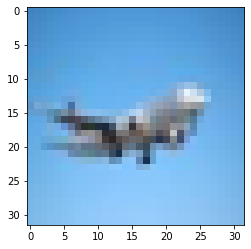

tensor(0)


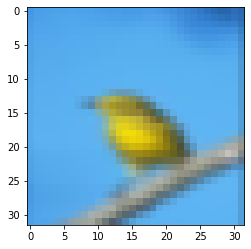

tensor(2)


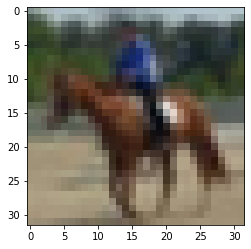

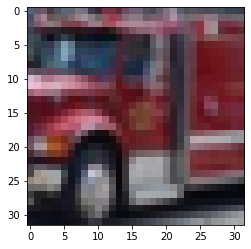

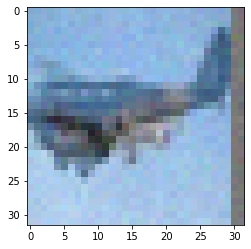

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)


In [433]:
x_imgs, x_labels = iter(train_loader).next()
u_imgs, _ = iter(train_loader).next()

show_img(x_imgs[0])
print(x_labels[0])
show_img(x_imgs[1])
print(x_labels[1])
show_img(u_imgs[0])
show_img(u_imgs[1])

mixmatch = MixMatch(model, 64, K=3)
x, u = mixmatch.run(x_imgs, x_labels, u_imgs)

x_prime = x[0]
p_prime = x[1]
u_prime = u[0]
q_prime = u[1]

show_img(x_prime[0])
print(p_prime[0])




In [406]:
p_prime

tensor([[[[0.0425, 0.6498, 0.0406, 0.0309, 0.0415, 0.0485, 0.0368, 0.0341,
           0.0336, 0.0417],
          [0.0421, 0.0439, 0.6465, 0.0308, 0.0415, 0.0489, 0.0369, 0.0338,
           0.0336, 0.0420]]],


        [[[0.0101, 0.9166, 0.0097, 0.0074, 0.0099, 0.0116, 0.0088, 0.0081,
           0.0080, 0.0099],
          [0.0100, 0.0105, 0.9159, 0.0073, 0.0099, 0.0116, 0.0088, 0.0081,
           0.0080, 0.0100]]]], dtype=torch.float64)

In [125]:
u_hat.requires_grad


False